# Домашняя работа

Будем работать с датасетом подержанных машин https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes.

Задача - построить прогноз цены машины по ее данным (год выпуска, пробег, расход, размер двигателя, тип коробки передач и тд). 

In [252]:
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [253]:
df_locs = [
    ('../data/audi.csv', 'Audi'),
    ('../data/bmw.csv', 'BMW'),
    # ('../data/cclass.csv', 'CClass'), # subtype of merc + contains less data (nan inside)
    # ('../data/focus.csv', 'Focus'),   # subtype of ford + contains less data (nan inside)
    ('../data/ford.csv', 'Ford'),
    ('../data/hyundi.csv', 'Hyundai'),
    ('../data/merc.csv', 'Mercedes'),
    ('../data/skoda.csv', 'Skoda'),
    ('../data/toyota.csv', 'Toyota'),
    ('../data/vauxhall.csv', 'Vauxhall'),
    ('../data/vw.csv', 'Volkswagen')
]

dfs = []

for loc, name in df_locs:
    df = pd.read_csv(loc)
    df['brand'] = name
    dfs.append(df)

dfa = pd.concat(dfs)
dfa['tax'] = dfa[['tax', 'tax(£)']].bfill(axis=1).iloc[:, 0]
dfa.drop(columns=['tax(£)'], inplace=True)

In [254]:
dfa.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,Audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,Audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,Audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,Audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,Audi


## Easy

Построить прогноз по одной марке машин при помощи решающих деревьев, взять только числовые признаки. В качестве метрики взять `r2_score`. Оценить важность признаков, проинтерпретировать модель.

In [255]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score

In [256]:
brand_name = 'Audi'

df = dfa[dfa['brand'] == brand_name]
df = df[['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']]

In [257]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [258]:
# model_DTR = DecisionTreeClassifier(max_depth=6, random_state=42)
model_DTR = DecisionTreeRegressor(max_depth=6, random_state=42)
model_DTR.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [259]:
train_prediction = model_DTR.predict(X_train)
test_prediction = model_DTR.predict(X_test)

train_accuracy = r2_score(train_prediction, y_train)
test_accuracy = r2_score(test_prediction, y_test)

print('Точность на обучающей выборке: ', train_accuracy)
print('Точность на тестовой выборке: ', test_accuracy)

Точность на обучающей выборке:  0.8786799800862414
Точность на тестовой выборке:  0.8600380048232739


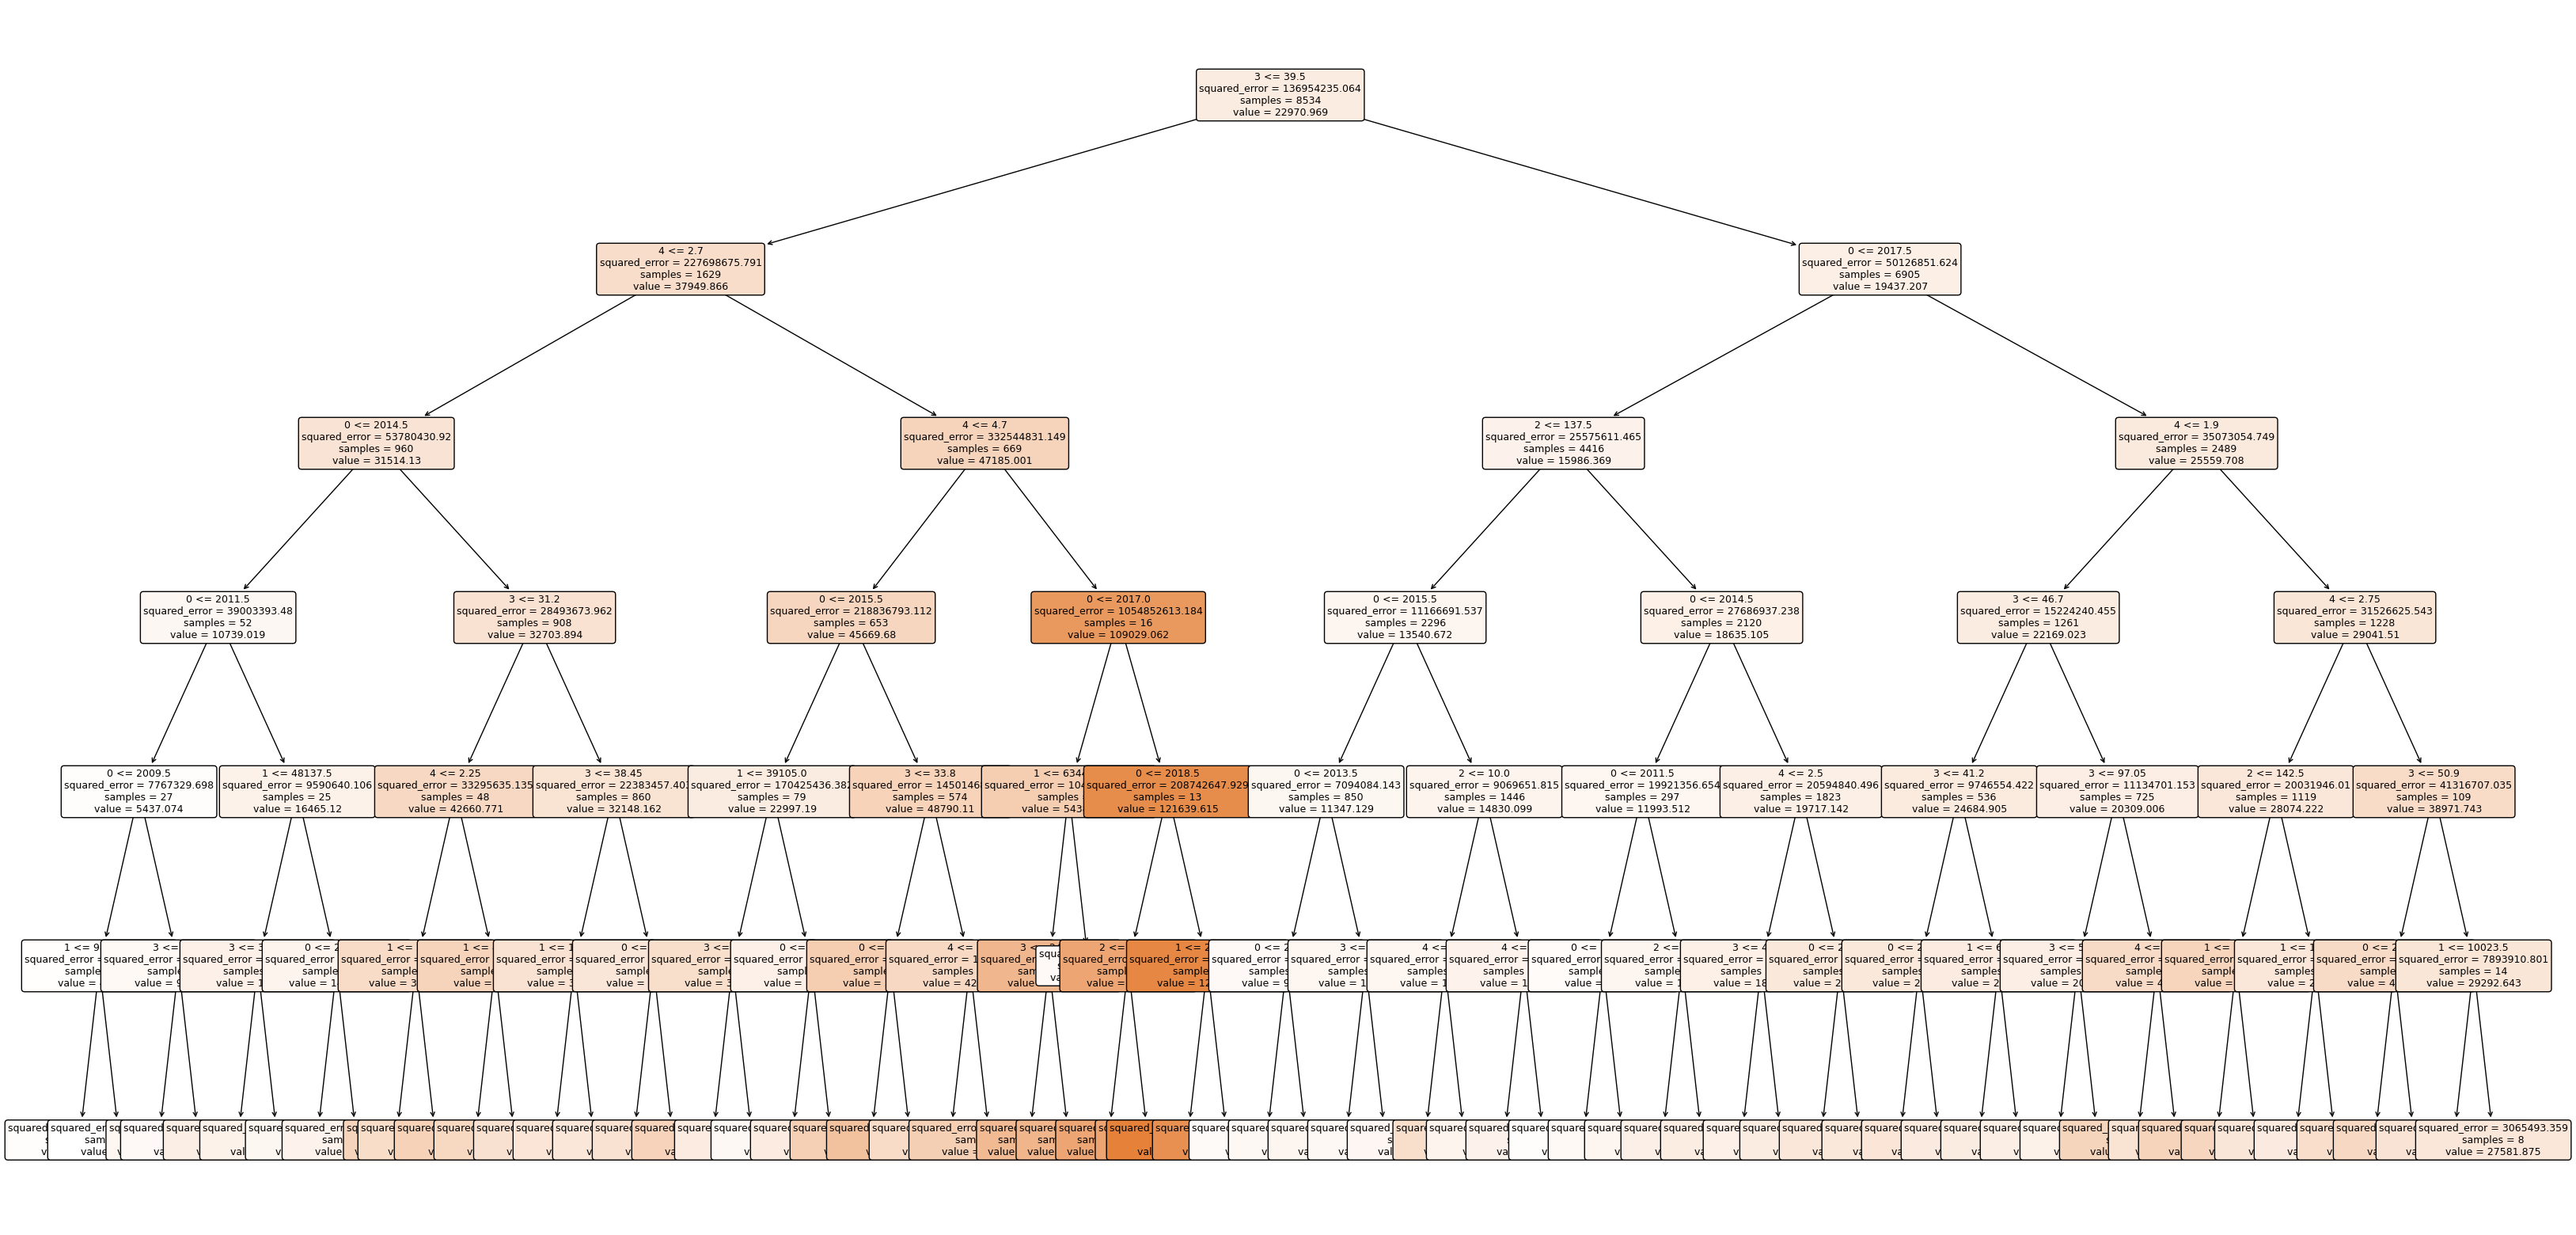

In [260]:
plt.figure(figsize=(40,20))  
plot_tree(model_DTR, feature_names = list(range(X_train.shape[1])), 
             filled=True, fontsize=9, rounded = True)
plt.show()

In [261]:
for i in ['year', 'mileage', 'tax', 'mpg', 'engineSize']:
    print('price and', i, 'correlation: ', df['price'].corr(df[i]))

price and year correlation:  0.592581456976229
price and mileage correlation:  -0.5353570952322908
price and tax correlation:  0.35615698997023654
price and mpg correlation:  -0.6003343844160697
price and engineSize correlation:  0.5912616428923322


### Выводы

Если оценивать корреляционную зависимость, то все параметры влияют на конечную цену примерно в равной степени, за исключением `mileage` и `tax`, что вполне логичной (`mileage` могут сбрасывать, а `tax` зависит от многих факторов и практически в последнюю очередь - от цены на вторичном рынке).

---

Если же оценивать решающее дерево, то тут в начале очень значимым признаком является `mpg`, а дальше - `engineSize`. При этом `tax` попадает в первую тройку слоёв, являясь столь же важным (или даже важнее), что и `mpg` (с максимальной корреляцией), а `mileage` - наоборот - практически не влияет на первоначальные решения. Это кажется довольно абсурдным, однако вполне закономерно. Дело в том, что при сильной связности и ненулевом разбросе признаки близкие к медиане могут быть далеки от медианы конечного числа, однако для мало связных признаков характерен немалый случайный разброс из-за чего выше вероятность того, что по этому признаку будет поделить проще и эффективнее.

Иными словами, разделяющее множество и коррелируемость совершенно разные штуки и наличие одного и не гарантирует наличие другого.

---

=> Комментарий, когда я случайно использовал классификацию (что, в целом было, тоже нормально из-за большого числа классов): 'Кстати говоря, первичное деление по `2019` (`2018.5`) году вполне логично. Данные заканчиваются `2020` годом, а как мы знаем, цены очень сильно снижаются при выходе машины на вторичный рынок. Т.о. машины после `2019` - абсолютно новые и цены на них будут сильно выше, чем на старые, до `2019`.
При этом, для новых машин мощность двигателя имеет второе место по значимости в цене, а для старых - налог (точно не понятно почему, однако я думаю это определить люксовости, т.к. для люксовых дальше имеет смыл мощность двигателя, а для не люксовых - километраж, что супер логично).'

Забавно, что регрессор выбрал совершенно другую стратегию и делит изначально по эффективности двигателя, а затем по мощности (для неэффективных машин, что в целом логично, ибо неэффективные машины, это обычно какие-нибудь спортивные машины, которые берут ради двигателя) и по году (для эффектных машин, ибо тут уже определяется комфортность).

In [262]:
impact = pd.DataFrame({'feature': model_DTR.feature_names_in_, 'impact': model_DTR.feature_importances_})
impact = impact.sort_values('impact', ascending=False)
print(impact)

      feature    impact
3         mpg  0.478609
0        year  0.259750
4  engineSize  0.214955
2         tax  0.034214
1     mileage  0.012472


(значения упорядочены по силе влияния)

Влияния параметров совпадают с выводами, так что не думаю, что тут стоит что-то комментировать.

## Normal

Объединить в один датафрейм данные по всем маркам машин. Преобразовать категориальные признаки.

Построить еще несколько моделей, используя подбор гиперпараметров. Сравнить между собой все построенные модели.

In [268]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [276]:
hyperparameters_DTR = {
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [*list(i for i in range(1, 30, 4)), None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

hyperparameters_DTC = {
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'max_depth': [*list(i for i in range(1, 30, 4)), None],
    'min_samples_split': [2, 3, 5],
}

In [277]:
search = GridSearchCV(DecisionTreeRegressor(), hyperparameters_DTR, n_jobs=-1, cv=5) # ~ 8 min x 16 logical processors
# search = RandomizedSearchCV(DecisionTreeRegressor(), hyperparameters_DTR, n_jobs=-1, cv=5, n_iter=100, random_state=42) # Way faster
search.fit(X_train, y_train)
search.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.001, criterion='friedman_mse', max_depth=17,
                      min_samples_split=5, splitter='random')

In [278]:
search_C = GridSearchCV(DecisionTreeClassifier(), hyperparameters_DTC, n_jobs=-1, cv=5) # ~ 2 min x 16 logical processors
# search_C = RandomizedSearchCV(DecisionTreeClassifier(), hyperparameters_DTC, n_jobs=-1, cv=5, n_iter=100, random_state=42) # Way faster
search_C.fit(X_train, y_train)
search_C.best_estimator_

C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


DecisionTreeClassifier(criterion='entropy', max_depth=25, max_features='log2')

In [279]:
model_DTR_HP = search.best_estimator_
model_DTR_HP.fit(X_train, y_train)

model_DTC_HP = search_C.best_estimator_
model_DTC_HP.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=25, max_features='log2')

In [280]:
y_pred_DTR_HP = model_DTR_HP.predict(X_test)
y_pred_DTC_HP = model_DTC_HP.predict(X_test)

DTR_HP_accuracy = r2_score(y_pred_DTR_HP, y_test)
DTC_HP_accuracy = r2_score(y_pred_DTC_HP, y_test)

print('DecisionTreeRegressor_HP accuracy: ', DTR_HP_accuracy)
print('DecisionTreeClassifier_HP accuracy: ', DTC_HP_accuracy)

DecisionTreeRegressor_HP accuracy:  0.9238244251543445
DecisionTreeClassifier_HP accuracy:  0.8395129193741535


Получили результаты довольно близкие к начальным (если не учитывать глубину, которая в первой моделе была специально маленькой). Вывод - модель из коробки `fine tuned`.


## Hard

Собрать датасет по одной модели на любом агрегаторе объявлений (модель должна быть из датасета). Сравнить какие признаки наиболее важны на нашем рынке, по сравнению с рынком в UK.

Сервисы не любят парсеры, поэтому скорее всего в автоматическом режиме не получится распарсить много данных. По-крайней мере, у меня не получилось как-то быстро обойти капчу. Поэтому:

- Можно вручную вбить в эксельку данные по нескольким десяткам машин
- Можно скачать несколько html и написать скрипт для их парсинга (можно использовать beautiful soup) - в таком подходе ожидаю больше сотни примеров
- Можно найти агрегатор без капчи или апишку (примеры - телеграм каналы, VK API) и собрать данные оттуда

In [ ]:
# Coming soon...